In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import csv
from numpy import mean, std
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, recall_score, mean_squared_error, accuracy_score, roc_auc_score
from matplotlib import pyplot
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

## Loading Dataset

In [ ]:
data_file = 'C:/Data/data.csv'

In [2]:
def get_data(data_file):
    X = []
    with open(data_file, newline='') as f:
        csv_reader = csv.reader(f)
        for i, row in enumerate(csv_reader):
            X.append(row)
    column_names = X.pop(0)
    X = pd.DataFrame(X, columns=column_names)
    y = X['result'].to_numpy().astype(np.float).astype(np.int)
    X = X.astype(float)
    y = y.astype(float)
    print(X.head(-10))
    X = X.drop(labels='result', axis=1)

    return X, y
X, y = get_data(data_file)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) 

       ci_cycle  history_length  previous_result  last_four_pass_rate  pass_rate  seconds_since_run  average_duration  result
0           0.0        0.000000              0.0                  0.0   0.000000                0.0          0.000000     0.0
1           0.0        0.000000              0.0                  0.0   0.000000                0.0          0.000000     1.0
2           0.0        0.000000              0.0                  0.0   0.000000                0.0          0.000000     1.0
3           0.0        0.000000              0.0                  0.0   0.000000                0.0          0.000000     0.0
4           0.0        0.000000              0.0                  0.0   0.000000                0.0          0.003154     0.0
...         ...             ...              ...                  ...        ...                ...               ...     ...
20841       1.0        0.831099              0.0                  0.0   0.106452                0.0          0.352985 

## Defining models

In [3]:
def get_stacking():
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    level0.append(('rf', RandomForestClassifier(max_depth=3, random_state=0)))

    level1 = LogisticRegression()
    model = StackingClassifier(estimators=level0, final_estimator=level1)
    return model

In [4]:
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['rf'] = RandomForestClassifier(max_depth=4)
    models['stacking'] = get_stacking()
    models['xgb'] = XGBClassifier(eta=0.3, max_depth=4, objective='binary:logistic')
    models['mlp'] = MLPClassifier(hidden_layer_sizes=(32, 32, 32), learning_rate='adaptive')
    
    return models

## Training and Results

In [5]:
models = get_models()
results, names = list(), list()

In [6]:
def evaluate_model(model):
    train_start = time.time()
    model.fit(X, y)
    train_end = time.time()

    train_time = round(train_end - train_start, 2)

    predictions_class = model.predict(X_test)

    try:
        predictions_prob = model.predict_proba(X_test)
        predictions_prob = predictions_prob[:, 1]
    except:
        predictions_prob = predictions_class
    
    rmse = mean_squared_error(y_test, predictions_prob)
    auc = roc_auc_score(y_test, predictions_prob)
    acc = accuracy_score(y_test, predictions_class)
    recall = recall_score(y_test, predictions_class)

    return acc, rmse, auc, recall, train_time

In [7]:
model_names = [name for name, model in models.items()]
metrics = ['model', 'Acc', 'RMSE', 'AUC', 'Recall', 'Training Time']
max_name_len = max([len(x) for x in model_names])
results = []
for name, model in models.items():
    acc, rmse, auc, recall, train_time = evaluate_model(model)
    results.append([name, acc, rmse, auc, recall, train_time])
    names.append(name)
    spacer = ' ' * (max_name_len - len(name))
    print('> %s | Acc = %.3f | RMSE = %.3f | AUC = %.3f | Recall = %.3f | Training Time = %.3f' % ((name + spacer), acc, rmse, auc, recall, train_time))
results = pd.DataFrame(results, columns = metrics)

> lr       | Acc = 0.916 | RMSE = 0.070 | AUC = 0.856 | Recall = 0.226 | Training Time = 0.070
> knn      | Acc = 0.926 | RMSE = 0.065 | AUC = 0.753 | Recall = 0.449 | Training Time = 0.260
> svm      | Acc = 0.924 | RMSE = 0.076 | AUC = 0.682 | Recall = 0.382 | Training Time = 1.150
> bayes    | Acc = 0.877 | RMSE = 0.122 | AUC = 0.846 | Recall = 0.367 | Training Time = 0.010
> rf       | Acc = 0.916 | RMSE = 0.063 | AUC = 0.854 | Recall = 0.288 | Training Time = 0.550
> stacking | Acc = 0.912 | RMSE = 0.079 | AUC = 0.719 | Recall = 0.268 | Training Time = 9.640
> xgb      | Acc = 0.926 | RMSE = 0.065 | AUC = 0.861 | Recall = 0.452 | Training Time = 0.940
> mlp      | Acc = 0.903 | RMSE = 0.076 | AUC = 0.862 | Recall = 0.412 | Training Time = 22.530


## Plot Results

In [8]:
def plot_bars(data_frame, group_by, x_axis, y_axis, highlight_series, col_wrap=3):

    series = data_frame[x_axis]
    groups = data_frame.columns.drop(labels=x_axis)
    series = list(series.drop_duplicates())
    data_frame = pd.melt(data_frame, id_vars=x_axis, var_name=group_by, value_name=y_axis)
    data_frame = data_frame.sort_values([y_axis], ascending=False)

    orange = sns.color_palette()[1]
    blue = sns.color_palette()[-1]
    palette = {series_name:orange if series_name in highlight_series else blue for series_name in series}
    g = sns.FacetGrid(data_frame, col=group_by, col_wrap=col_wrap, height=3.2, aspect=1.8, sharey=False, sharex=False, col_order=groups)
    g.map(sns.barplot, x_axis, y_axis, palette=palette)
    g.fig.subplots_adjust(hspace=0.4, wspace=0.1)
    for ax in g.axes.ravel():
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.3f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center',
                        va = 'center',
                        xytext = (0, 10),
                        textcoords = 'offset points')
        for item in ax.get_xticklabels():
            item.set_rotation(20)

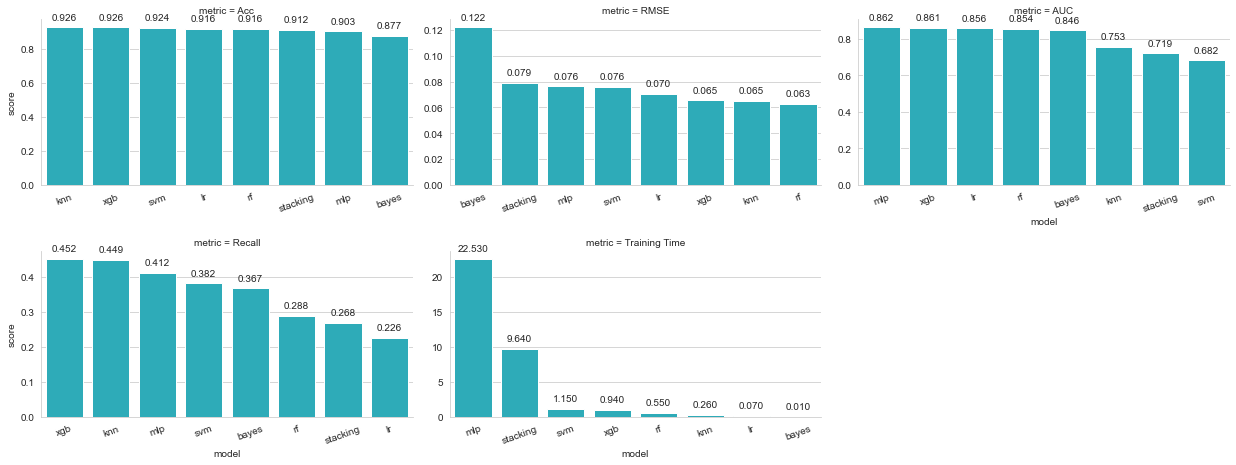

In [9]:
plot_bars(results, 'metric', 'model', 'score', [])

### Feature Importance

In [10]:
def feature_importance(model, name, X, y, print_=False):
    r = permutation_importance(model, X, y, n_repeats=30, random_state=0)
    spacer = ' '*(22-int(len(name)/2))
    feature_dict = {feature:0 for feature in X.columns}
    if print_:
        print('================================================')
        print(spacer, name ,spacer)
        print('================================================')
        print('idx         feature        importance       std')
        print('================================================')
    for i in r.importances_mean.argsort()[::-1]:
        spacer = ' '*(20-len(X.columns[i]))
        feature_dict[X.columns[i]] = r.importances_mean[i]
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            if print_:
                print(i, '|', spacer, f"{X.columns[i]:<8} ", '|', f"{r.importances_mean[i]:.3f} ", '|', f" +/- {r.importances_std[i]:.3f} ")
    if print_:
        print('================================================')

    feature_list = [value for key, value in feature_dict.items()]

    return feature_list

In [13]:
feature_lists = [list(X.columns.insert(0, 'model'))]
for name, model in models.items():
    feature_list = feature_importance(model, name, X_test, y_test, print_=True)
    feature_lists.append([name] + feature_list)

                      lr                      
idx         feature        importance       std
3 |   last_four_pass_rate  | 0.012  |  +/- 0.001 
                      knn                      
idx         feature        importance       std
3 |   last_four_pass_rate  | 0.030  |  +/- 0.003 
4 |             pass_rate  | 0.026  |  +/- 0.002 
2 |       previous_result  | 0.010  |  +/- 0.001 
6 |      average_duration  | 0.005  |  +/- 0.001 
                      svm                      
idx         feature        importance       std
3 |   last_four_pass_rate  | 0.030  |  +/- 0.002 
4 |             pass_rate  | 0.020  |  +/- 0.002 
2 |       previous_result  | 0.006  |  +/- 0.001 
                     bayes                     
idx         feature        importance       std
2 |       previous_result  | 0.036  |  +/- 0.003 
3 |   last_four_pass_rate  | 0.026  |  +/- 0.002 
                      rf                      
idx         feature        importance       std
3 |   last_four_pass_r

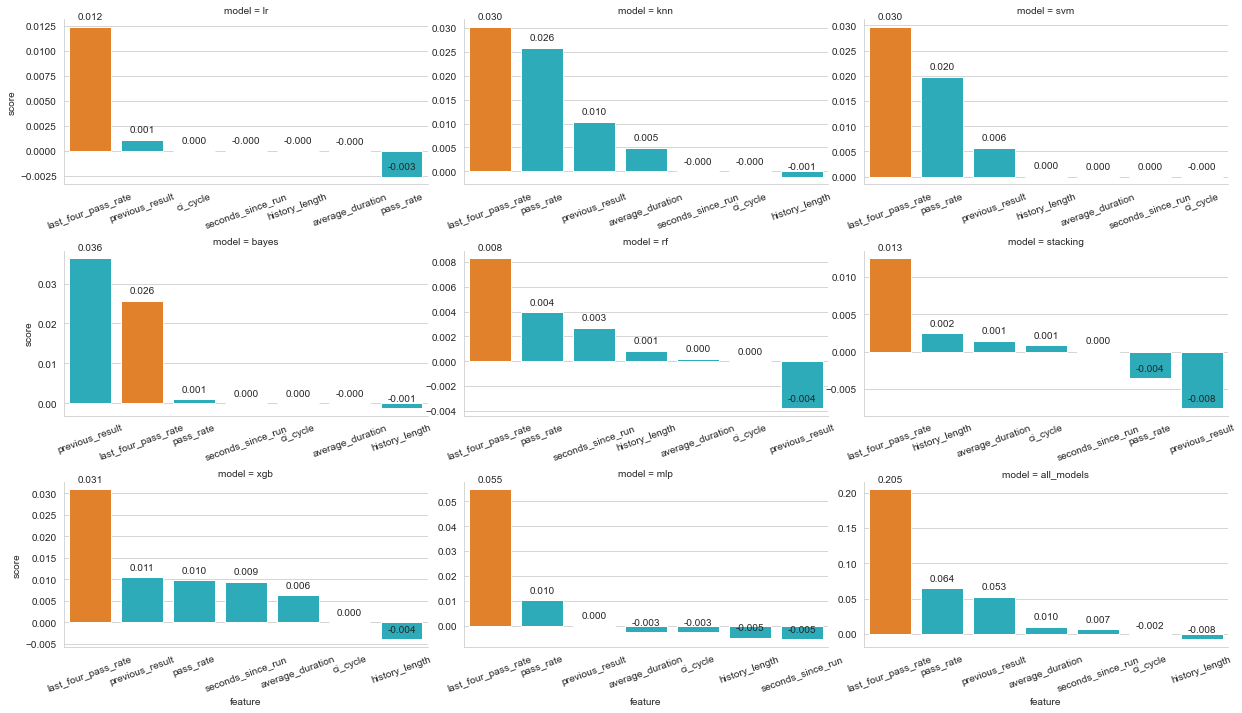

In [12]:
feature_lists_df = pd.DataFrame(feature_lists).T
column_names = ['feature'] + list(feature_lists_df.iloc[0])[1:]
feature_lists_df = feature_lists_df.iloc[1:]
feature_lists_df.columns = column_names

feature_names = feature_lists[0][1:]
sum_features = feature_lists_df.drop(columns=['feature'])
sum_features = list(sum_features.sum(axis=1))
feature_lists_df['all_models'] = sum_features
best_feature =  feature_names[sum_features.index(max(sum_features))]
sum_features = pd.DataFrame([sum_features], columns=feature_names)


plot_bars(feature_lists_df, 'model', 'feature', 'score', [best_feature])